# OPERA Surface Displacement from Sentinel-1 Access and Visualize

Authors: Harshini Girish (UAH), Rajat Shinde (UAH), Alex Mandel (Development Seed), Chuck Daniels (Development Seed)

Date:July 16, 2025

Description: This tutorial aims to provide information and code to help users get started working with the OPERA Sentinel-1 Surface Displacement product using the MAAP. We will search for the data within NASA’s Common Metadata Repository (CMR).

## Run This Notebook

To access and run this tutorial within MAAP’s Algorithm Development Environment (ADE), please refer to the “Getting started with the MAAP” section of our documentation.

Disclaimer: It is highly recommended that you run this tutorial within MAAP’s ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.



## About the Data

The Level-3 OPERA Sentinel-1 Surface Displacement (DISP) product is generated through interferometric time-series analysis of Level-2 Coregistered Sentinel-1 Single Look Complex (CSLC) datasets. Using a hybrid Persistent Scatterer (PS) and Distributed Scatterer (DS) approach, this product quantifies Earth's surface displacement in the radar line-of-sight. The DISP products enable the detection of anthropogenic and natural surface changes, including subsidence, tectonic deformation, and landslides. 

The OPERA DISP suite comprises complementary datasets derived from Sentinel-1 and NISAR inputs, designated as DISP-S1 and DISP-NI, respectively. Each product, created per acquisition, adheres to a consistent structure, HDF5 file format, file-naming convention, and a 30 m spatial posting. This collection specifically includes DISP-S1 products, derived from Sentinel-1 data. For visualization and quick exploration, the Pangeo Image can be used for these datasets. 


Source: [OPERA Surface Displacement from Sentinel-1](https://cmr.earthdata.nasa.gov/search/concepts/C3294057315-ASF.html)

## Importing Packages

You can access data from Jupyter Notebook within your workspace. In your Jupyter Notebook, start by importing the `maap` package. Then invoke the `MAAP` constructor, setting the `maap_host` argument to `'api.maap-project.org'`


In [ ]:
# --- MAAP & Cloud Access ---
from maap.maap import MAAP
import earthaccess
from s3fs import S3FileSystem

# File Access & Processing -
import os
import fsspec
import h5py
import re
import numpy as np
import xarray as xr
import dask

# Plotting & Visualization 
import matplotlib.pyplot as plt
import folium

#  Geospatial 
import geopandas as gpd
from shapely.geometry import box, Polygon

# Misc
import requests
from pprint import pprint

# Initialize MAAP
maap = MAAP()


## Searching the Data

This performs a granule search using the `maap.searchGranule()` function on the OPERA Sentinel-1 displacement product collection.

In [2]:
collection = maap.searchCollection(
    cmr_host="cmr.earthdata.nasa.gov",
    short_name="OPERA_L3_DISP-S1_V1"
)
len(collection)

1

In [3]:

concept_id = collection[0]["concept-id"]
print(concept_id)


C3294057315-ASF


In [4]:
results = maap.searchGranule(
    concept_id=concept_id,
    cmr_host="cmr.earthdata.nasa.gov",
    limit=100
)

records = []
for r in results:
    granule = r["Granule"]
    try:
        points = granule["Spatial"]["HorizontalSpatialDomain"]["Geometry"]["GPolygon"]["Boundary"]["Point"]
        coords = [(float(p["PointLongitude"]), float(p["PointLatitude"])) for p in points]
        if len(coords) >= 3:
            polygon = Polygon(coords)
            records.append({
                "GranuleUR": granule["GranuleUR"],
                "geometry": polygon
            })
    except KeyError:
        continue
if records:
    gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")
    print(f"Found {len(gdf)} granules with polygons.")

    

Found 100 granules with polygons.


## Visualizing with Bounding Boxes

This code creates an interactive map showing bounding boxes for each granule using `folium`. It extracts geometry bounds from a `GeoDataFrame`, constructs a new `GeoDataFrame` of bounding boxes, and overlays them on a Leaflet map with tooltips displaying each granule's ID.


In [5]:
bounding_boxes = []
granule_ids = []

for i, geom in enumerate(gdf.geometry):
    minx, miny, maxx, maxy = geom.bounds
    bounding_boxes.append(box(minx, miny, maxx, maxy))  
    granule_ids.append(gdf["GranuleUR"][i])


bbox_gdf = gpd.GeoDataFrame({
    "GranuleUR": granule_ids,
    "geometry": bounding_boxes
}, crs="EPSG:4326")


map_center = bbox_gdf.geometry.union_all().centroid
m = folium.Map(location=[map_center.y, map_center.x], zoom_start=6)


for _, row in bbox_gdf.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda x: {
            "color": "green",
            "weight": 2,
            "fillOpacity": 0.1
        },
        tooltip=row["GranuleUR"]
    ).add_to(m)

m


## Search Granules using filters

### Temporal Filter

Now that we have our collection ID, let’s search for granules within the collection. We’ll also add a temporal filter to our search. If you would like to search for granules without the temporal filter, simply comment out or remove the `temporal=date_range` line.

In [6]:
date_range = "2016-07-01T00:00:00Z,2016-07-25T23:59:59Z"

results = maap.searchGranule(
    temporal=date_range,
    concept_id="C3294057315-ASF",
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170109T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160818T005800Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161029T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170310T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170403T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170202T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170214T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170226T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161005T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170322T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_201607

### Spatial Filter

Another filter we can apply is a spatial filter.

In [7]:
granule_bbox = "-104.57446,23.91956,-101.85669,25.95518" 
collection_id = "C3294057315-ASF"

results = maap.searchGranule(
    concept_id=collection_id,
    bounding_box=granule_bbox,
    cmr_host="cmr.earthdata.nasa.gov"
)

print(f"Found {len(results)} granules")
for r in results:
    print(r["Granule"]["GranuleUR"])


Found 20 granules
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170109T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160818T005800Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161029T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170310T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170403T005759Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170202T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170214T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170226T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20161005T005802Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20170322T005758Z_v1.0_20250412T124848Z
OPERA_L3_DISP-S1_IW_F40292_VV_201607

## Locally download and Inspect 

This code snippet queries NASA’s CMR via the MAAP API to fetch a granule from the `OPERA_L3_DISP-S1_V1` collection and downloads it locally into a folder called `opera_data`. It then uses `xarray.open_dataset()` with the `h5netcdf` engine to open the local NetCDF file and inspects its structure, including its shape, coordinates, and variable metadata.


In [14]:
results = maap.searchGranule(
    short_name="OPERA_L3_DISP-S1_V1",
    cmr_host="cmr.earthdata.nasa.gov"
)


data_dir = "opera_data"
os.makedirs(data_dir, exist_ok=True)


file_path = results[0].getData(data_dir)

ds = xr.open_dataset(file_path, engine="h5netcdf")
print(ds)


<xarray.Dataset> Size: 3GB
Dimensions:                         (y: 8036, x: 9614, time: 1)
Coordinates:
  * y                               (y) float64 64kB 2.881e+06 ... 2.64e+06
  * x                               (x) float64 77kB 5.339e+05 ... 8.223e+05
  * time                            (time) datetime64[ns] 8B 2016-07-25T00:57...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B ...
    displacement                    (y, x) float32 309MB ...
    short_wavelength_displacement   (y, x) float32 309MB ...
    recommended_mask                (y, x) float32 309MB ...
    connected_component_labels      (y, x) float32 309MB ...
    ...                              ...
    estimated_phase_quality         (y, x) float32 309MB ...
    persistent_scatterer_mask       (y, x) float32 309MB ...
    shp_counts                      (y, x) float32 309MB ...
    water_mask                      (y, x) float32 309MB

## Visualization

This plot visualizes the radar Line-of-Sight (LOS) displacement from an OPERA DISP-S1 granule. . The displacement field is displayed with a diverging colormap, highlighting motion towards and away from the sensor.


In [12]:
ds["displacement"].attrs


{'units': 'meters',
 'description': 'Displacement along the radar Line-of-Sight (LOS) direction. Positive values indicate apparent motion towards the platform.',
 'long_name': 'Line-of-sight displacement',
 'grid_mapping': 'spatial_ref'}

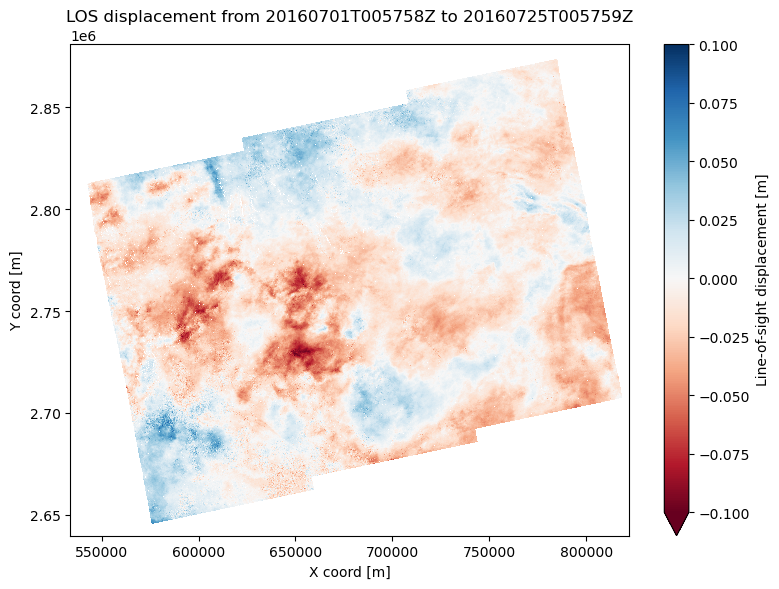

In [18]:
gname = results[0]["Granule"]["GranuleUR"]
t = re.search(r'_(\d{8}T\d{6}Z)_(\d{8}T\d{6}Z)', gname)
ts = f"{t.group(1)} to {t.group(2)}" if t else "Time unknown"

ds["displacement"].squeeze().plot(
    cmap="RdBu", vmin=-0.1, vmax=0.1, figsize=(8, 6),
    cbar_kwargs={"label": "Line-of-sight displacement [m]"}
)
plt.title(f"LOS displacement from {ts}")
plt.xlabel("X coord [m]"); plt.ylabel("Y coord [m]")
plt.tight_layout(); plt.show()


## Remote Access

This example streams a NetCDF file directly from AWS S3 using `fsspec` and valid Earthdata S3 credentials. The `getDownloadUrl()` method fetches the granule's S3 path, which is securely accessed using temporary keys. The dataset is then opened with `xarray` using the `h5netcdf` engine, without needing to download the file locally.


In [21]:
results = maap.searchGranule(
    concept_id="C3294057315-ASF",
    cmr_host="cmr.earthdata.nasa.gov",
    limit=10,
)


print(results[0].getDownloadUrl())


credentials = maap.aws.earthdata_s3_credentials(
    'https://cumulus.asf.alaska.edu/s3credentials'
)


s3 = fsspec.filesystem(
    "s3",
    key=credentials['accessKeyId'],
    secret=credentials['secretAccessKey'],
    token=credentials['sessionToken']
)



s3://asf-cumulus-prod-opera-products/OPERA_L3_DISP-S1_V1/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z/OPERA_L3_DISP-S1_IW_F40292_VV_20160701T005758Z_20160725T005759Z_v1.0_20250412T124848Z.nc


In [22]:
with s3.open(results[0].getDownloadUrl(), "rb") as f:
    ds = xr.open_dataset(f, engine="h5netcdf")
    print(ds)


<xarray.Dataset> Size: 3GB
Dimensions:                         (y: 8036, x: 9614, time: 1)
Coordinates:
  * y                               (y) float64 64kB 2.881e+06 ... 2.64e+06
  * x                               (x) float64 77kB 5.339e+05 ... 8.223e+05
  * time                            (time) datetime64[ns] 8B 2016-07-25T00:57...
Data variables: (12/13)
    spatial_ref                     int64 8B ...
    reference_time                  (time) datetime64[ns] 8B ...
    displacement                    (y, x) float32 309MB ...
    short_wavelength_displacement   (y, x) float32 309MB ...
    recommended_mask                (y, x) float32 309MB ...
    connected_component_labels      (y, x) float32 309MB ...
    ...                              ...
    estimated_phase_quality         (y, x) float32 309MB ...
    persistent_scatterer_mask       (y, x) float32 309MB ...
    shp_counts                      (y, x) float32 309MB ...
    water_mask                      (y, x) float32 309MB

## Visualization

The plot shows pixel-level surface displacement values without downloading the file locally.

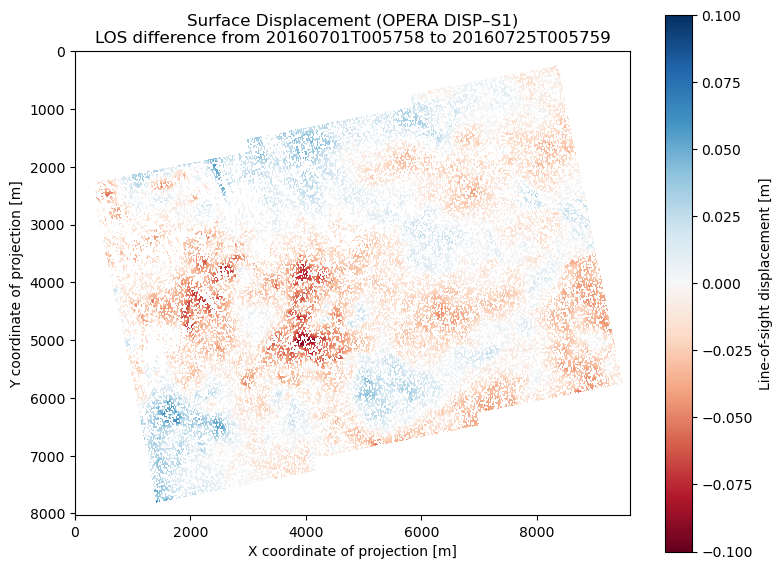

In [29]:
url = results[0].getDownloadUrl()
match = re.search(r'_(\d{8}T\d{6})Z_(\d{8}T\d{6})Z', url)
start_date, end_date = match.groups() if match else ("Unknown", "Unknown")
with (
    s3.open(results[0].getDownloadUrl(), "rb") as f,
    h5py.File(f, "r") as opera_data,
):
    displacement_data = opera_data["displacement"][:]
    displacement_data = np.ma.masked_where(np.isnan(displacement_data), displacement_data)

   
    plt.figure(figsize=(8, 6))
    im = plt.imshow(displacement_data, cmap="RdBu", vmin=-0.1, vmax=0.1)
    cbar = plt.colorbar(im)
    cbar.set_label("Line-of-sight displacement [m]")

    plt.title(
        f"Surface Displacement (OPERA DISP–S1)\nLOS difference from {start_date} to {end_date}"
    )
    plt.xlabel("X coordinate of projection [m]")
    plt.ylabel("Y coordinate of projection [m]")
    plt.tight_layout()
    plt.show()


## Testing Cloud Optimization

This setup enables efficient streaming of large NetCDF files from NASA’s cloud using `earthaccess` and `fsspec`. By specifying `blockcache` and tuning HDF5 driver settings like `page_buf_size` and `rdcc_nbytes`, it optimizes chunked reads. The dataset is opened in-memory with `xr.open_dataset()` using `h5netcdf`, without downloading locally.


In [22]:
auth = earthaccess.login()

granules = earthaccess.search_data(
    count=1,
    short_name="OPERA_L3_DISP-S1_V1"
)
granule = granules[0]
url = granule.data_links(access="direct")[0]

credentials = auth.get_s3_credentials(
    endpoint=granule.get_s3_credentials_endpoint()
)

s3 = S3FileSystem(
    key=credentials['accessKeyId'],
    secret=credentials['secretAccessKey'],
    token=credentials['sessionToken']
)


INFO:earthaccess.api:Granules found: 55136


In [24]:
io_params = {
    "fsspec_params": {
        "cache_type": "blockcache",
        "block_size": 8 * 1024 * 1024
    },
    "h5py_params": {
        "driver_kwds": {
            "page_buf_size": 16 * 1024 * 1024,
            "rdcc_nbytes": 4 * 1024 * 1024
        }
    }
}


In [27]:
with s3.open(url, "rb", **io_params["fsspec_params"]) as f:
    ds = xr.open_dataset(
        f,
        engine="h5netcdf",
        chunks="auto",  
        **io_params["h5py_params"]
    )



Each data variable (e.g., `displacement`, `temporal_coherence`) is chunked along spatial dimensions — typically `(5632, 2404)` or `(5632, 3982)`. This chunking enables partial reads using HTTP range requests via `fsspec` without loading the full file. It's ideal for efficient access in cloud environments.


In [28]:
for var_name, variable in ds.data_vars.items():
    print(f"Variable '{var_name}': chunks = {variable.chunks}")


Variable 'spatial_ref': chunks = None
Variable 'reference_time': chunks = ((1,),)
Variable 'displacement': chunks = ((5632, 2404), (5632, 3982))
Variable 'short_wavelength_displacement': chunks = ((5632, 2404), (5632, 3982))
Variable 'recommended_mask': chunks = ((5632, 2404), (5632, 3982))
Variable 'connected_component_labels': chunks = ((5632, 2404), (5632, 3982))
Variable 'temporal_coherence': chunks = ((5632, 2404), (5632, 3982))
Variable 'estimated_phase_quality': chunks = ((5632, 2404), (5632, 3982))
Variable 'persistent_scatterer_mask': chunks = ((5632, 2404), (5632, 3982))
Variable 'shp_counts': chunks = ((5632, 2404), (5632, 3982))
Variable 'water_mask': chunks = ((5632, 2404), (5632, 3982))
Variable 'phase_similarity': chunks = ((5632, 2404), (5632, 3982))
Variable 'timeseries_inversion_residuals': chunks = ((5632, 2404), (5632, 3982))


## cloud-optimized performance

The mean along the `'x'` dimension of the `displacement` variable executes in milliseconds. The output shows chunking as `(5632,)`, meaning only necessary chunks are accessed. This highlights optimal use of Dask and cloud-optimized NetCDF for fast, partial computation.


In [29]:
%time ds['displacement'].mean(dim='x')


CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2 ms


<xarray.DataArray 'displacement' (y: 8036)> Size: 32kB
dask.array<mean_agg-aggregate, shape=(8036,), dtype=float32, chunksize=(5632,), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 64kB 2.881e+06 2.881e+06 ... 2.64e+06 2.64e+06